In [1]:
# Import and Dataset Definition 
import os 
from pathlib import Path 
from PIL import Image 
import torch 
import torchvision.transforms as transforms 
from torch.utils.data import Dataset, DataLoader 
from pycocotools.coco import COCO 

# configuration 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DATASET CLASS 
class ColorizationDataset(Dataset): 
    def __init__(self, root_dir = '/home/ks6hd/coco_project/', split='val2017', ann_file='annotations/instances_val2017.json'): 
        """
        root_dir = folder that contains images and annotations 
        split = subfolder to look in ('val2017')
        ann_file = path to finding JSON file containing class labels
        """
        self.root_dir = Path(root_dir)
        self.split = split 

        # Path to Grayscale and color 
        self.gray_dir = self.root_dir / "images_512_gray" / split
        self.rgb_dir = self.root_dir / "images_512" / split
        self.ann_path = self.root_dir / ann_file

        # USEING COCO API 
        self.coco = COCO(self.ann_path) 

        # List of all image IDs available in COCO annotation file 
        self.ids = list(sorted(self.coco.imgs.keys()))

        # Define Transforms 
        self.transform = transforms.Compose([
            transforms.ToTensor(), # convert 0-255 pixels to 0.0-1.0 tensors 
        ])

    def __len__(self): 
        return len(self.ids) 

    def __getitem__(self, idx): 
        # get ID 
        img_id = self.ids[idx]
        # get filename 
        file_info = self.coco.loadImgs(img_id)[0]
        filename = file_info['file_name']
    
        # load Images 
        gray_path = self.gray_dir / filename 
        rgb_path = self.rgb_dir / filename 
    
        # Checking again if image black and white / color 
        gray_image = Image.open(gray_path).convert('L') 
        rgb_image = Image.open(rgb_path).convert('RGB') 
    
        # Get Labels 
        ann_ids = self.coco.getAnnIds(imgIds=img_id) 
        anns = self.coco.loadAnns(ann_ids)
        category_id = anns[0]['category_id'] if len(anns) > 0 else 0  # ONLY GRAB FIRST LABEL 
    
        # Transform 
        gray_tensor = self.transform(gray_image).repeat(3,1,1) # (gray, gray, gray) isntead of (red, green, blue) 
        rgb_tensor = self.transform(rgb_image) 
    
        return gray_tensor, rgb_tensor, category_id # Returning gray scale image / real image / classification

temp_ds = ColorizationDataset(root_dir='/home/ks6hd/coco_project', split='val2017')

loading annotations into memory...
Done (t=0.82s)
creating index...
index created!
✅ SUCCESS! Dataset length is: 5000


In [12]:
# Model Architecture (ResNet50 + CBAM) 
import torch
import torch.nn as nn 
import torchvision.models as models 

# PART 1: Attention Modules 
class ChannelAttention(nn.Module): 
    def __init__(self, in_planes, ratio = 16): 
        super(ChannelAttention, self).__init__() 
        # 1. Pooling Layers 
        ## squash the height/width to 1 x 1 so we can analyze content of the channels 
        self.avg_pool = nn.AdaptiveAvgPool2d(1) # takes average value of feature map (understanding background)
        self.max_pool = nn.AdaptiveMaxPool2d(1) # takes maximal value of feature map (finding distinctive object part) 
        # 2. Shared MLP (multi-layer perceptron) 
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias = False)  # forces features to be summarized into smaller key concepts 
        self.relu1 = nn.ReLU()                                                # allowing negative (unimportant) features to 0 
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias = False) # maps summarized concepts back into original features to generate score 
        # 3. Sigmoid 
        # Force output (scores) to be between 0 and 1 
        self.sigmoid = nn.Sigmoid() 
    def forward(self, x): 
        # Calculate average and max attention separately, and add them 
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out 
        return self.sigmoid(out) 

class SpatialAttention(nn.Module): 
    def __init__(self, kernel_size = 7): 
        super(SpatialAttention, self).__init__()
        # 1. Convolution Layer - Takes output (avg+max) and outputs 1 heatmap of target 
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding = kernel_size//2, bias = False)
        self.sigmoid = nn.Sigmoid() 
    def forward(self, x): 
        # 1. Squash Channels - take mean and max across the depth (channels) of the image 
        ## Result = [Batch, 1 (Channel), H(height), W(Width)] for each
        avg_out = torch.mean(x, dim = 1, keepdim = True) 
        max_out, _ = torch.max(x, dim = 1, keepdim = True) 
        x_cat = torch.cat([avg_out, max_out], dim = 1) 
        out = self.conv1(x_cat) 
        return  self.sigmoid(out) 

# Main CBAM (orginize two submodules (channel attention and spatial attention) and make sure they run in correct order 
# step 1 (channel) turn down volume on unimportant channels 
# step 2 (spatial) drawing circle around target 
# step 3 (combine) black out everything outside that circle 
# output : clean features + map (circle) 
class CBAM(nn.Module): 
    def __init__(self, in_planes, ratio = 16, kernel_size = 7): 
        super(CBAM, self).__init__()
        # initialize two modules define above 
        self.ca = ChannelAttention(in_planes, ratio) 
        self.sa = SpatialAttention(kernel_size) 
    def forward(self, x):
        # 1. apply Channel Attention (reweight the features)
        x = x * self.ca(x)
        # 2. apply spatial attention (re weight the spatial location) 
        spatial_map = self.sa(x) 
        # 3. apply map to features 
        result = x * spatial_map 
        # return result and map 
        return result, spatial_map 

# PART 2. Resnet50 Integration 
class ResNetCBAM(nn.Module): 
    def __init__(self, num_classes = 91):  # class 91 because COCO dataset has ID numbers upto 90 
        super(ResNetCBAM, self).__init__() 
        # Load ResNet50 
        base_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        # keep early layers (encoder)
        # take layer 0 to 3 from downloaded model and group them into single block (initial_layers) 
        ## these are low level visions (lines, curves, textures) that don't need to be changed 
        self.initial_layers = nn.Sequential(
            base_model.conv1, base_model.bn1, base_model.relu, base_model.maxpool, 
            base_model.layer1, base_model.layer2, base_model.layer3
        ) 
        # isolate layer 4 (final convolutional block) -> want to insert CBAM module after this layer 
        self.layer4 = base_model.layer4
        
        # Update Channel Count to 2048 
        ## ResNet50 outputs 2048 channels 
        self.cbam = CBAM(in_planes = 2048) 
        self.avgpool = base_model.avgpool 
        # update Classifier Head 
        self.fc = nn.Linear(2048, num_classes) # final decision maker 
   
    def forward(self, x): 
        x = self.initial_layers(x) # pass through encoder 
        x = self.layer4(x)         # pass through final ResNet block 
        # apply attention          
        x, attn_map = self.cbam(x) 
        # classification Head 
        x_vec = self.avgpool(x)    
        x_vec = torch.flatten(x_vec, 1)
        logits = self.fc(x_vec)        # final guess 

        return logits, attn_map 

# Create Model Object 
model = ResNetCBAM(num_classes = 91).to(device) 
     

In [17]:
# Training Loop 
import torch.optim as optim 
from tqdm import tqdm 

# 1. Hyperparameters 
BATCH_SIZE = 8 # lowered to prevent memory crash 
LR = 1e-5  # learning rate 
EPOCHS = 10 # number of times to go through the whole dataset
LAMBDA_SPARSITY = 1

# 2. Set up 
# Reinitialize dataset to be safe 
dataset = ColorizationDataset(root_dir='/home/ks6hd/coco_project', split='val2017')
# Data loader 
train_loader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 1) 
# loss function (measure how wrong the model was) 
criterion = nn.CrossEntropyLoss() 
# Optimizer
optimizer = optim.Adam(model.parameters(), lr = LR) 

# 3. training loop 
print(f"starting training for {EPOCHS} on {device}..")
for epoch in range(EPOCHS): 
    model.train() # Switching model to training mode 
    running_loss = 0.0 
    # progress bar (not needed but was added to check progress) 
    loop = tqdm(train_loader, desc = f"Epoch {epoch+1}/{EPOCHS}")

    for batch_idx, (gray_imgs, rgb_imgs, labels) in enumerate(loop): 
        # moving data to GPU 
        gray_imgs = gray_imgs.to(device) 
        labels = labels.to(device).long() 
        # forward pass
        optimizer.zero_grad() # wiping so error from batches do not mess up
        outputs, attn_map = model(gray_imgs) 
        # calculate loss 
        cls_loss = criterion(outputs, labels) # comparing output to the labels  
        map_mean = torch.mean(attn_map)
        sparsity_loss = LAMBDA_SPARSITY * map_mean
        # Total Loss 
        loss = cls_loss + sparsity_loss
        
        # backward pass (Learning) 
        loss.backward() 
        optimizer.step()
        # update bar 
        running_loss += loss.item() 
        loop.set_postfix(loss=loss.item())
# saving checkpoint every epoch 
    torch.save(model.state_dict(), f"stage1_ResNet50_Epoch_{epoch+1}.pth")
    print(f" Epoch {epoch+1} Finished. Average loss : {running_loss / len(train_loader):.4f}")

print("training complete") 

loading annotations into memory...
Done (t=1.02s)
creating index...
index created!
starting training for 10 on cuda..


Epoch 1/10: 100%|██████████| 625/625 [02:26<00:00,  4.28it/s, loss=0.302]


 Epoch 1 Finished. Average loss : 0.3578


Epoch 2/10: 100%|██████████| 625/625 [02:25<00:00,  4.29it/s, loss=0.333]


 Epoch 2 Finished. Average loss : 0.2714


Epoch 3/10: 100%|██████████| 625/625 [02:25<00:00,  4.30it/s, loss=0.26] 


 Epoch 3 Finished. Average loss : 0.2314


Epoch 4/10: 100%|██████████| 625/625 [02:26<00:00,  4.27it/s, loss=0.226]


 Epoch 4 Finished. Average loss : 0.2033


Epoch 5/10: 100%|██████████| 625/625 [02:25<00:00,  4.30it/s, loss=0.131]


 Epoch 5 Finished. Average loss : 0.1769


Epoch 6/10: 100%|██████████| 625/625 [02:25<00:00,  4.29it/s, loss=0.105] 


 Epoch 6 Finished. Average loss : 0.1561


Epoch 7/10: 100%|██████████| 625/625 [02:25<00:00,  4.29it/s, loss=0.109] 


 Epoch 7 Finished. Average loss : 0.1408


Epoch 8/10: 100%|██████████| 625/625 [02:26<00:00,  4.28it/s, loss=0.0945]


 Epoch 8 Finished. Average loss : 0.1308


Epoch 9/10: 100%|██████████| 625/625 [02:26<00:00,  4.27it/s, loss=0.0822]


 Epoch 9 Finished. Average loss : 0.1150


Epoch 10/10: 100%|██████████| 625/625 [02:27<00:00,  4.25it/s, loss=0.114] 


 Epoch 10 Finished. Average loss : 0.1042
training complete


In [22]:
# CELL 7: Generate and Save Maps
import numpy as np
import os
import torch.nn.functional as F 

# 1. Configuration
# Specific folder  
output_dir = dataset.root_dir / "attention_maps" / "val2017"
os.makedirs(output_dir, exist_ok=True)

# 2. Sequential Loader 
gen_loader = DataLoader(dataset, batch_size = 1, shuffle = False, num_workers = 1) # batch = 1 easily match filenames one by one 

model.eval()

with torch.no_grad():
    for idx, (gray_img, rgb_img, label) in enumerate(tqdm(gen_loader)):
        # A. Run Model
        gray_img = gray_img.to(device)
        outputs, attn_map = model(gray_img)
        # B. Process Map
        # Resize to 512x512 to match original image size
        heatmap = F.interpolate(attn_map, size=(512, 512), mode='bilinear', align_corners=False)
        # Convert to Numpy
        heatmap = heatmap.squeeze().cpu().numpy()
        # Normalize (0 to 1) - ensure black is 0 and bright is 1 
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
        # C. Get Filename (use data index to find file name) 
        img_id = dataset.ids[idx]
        file_info = dataset.coco.loadImgs(img_id)[0]
        filename = file_info['file_name'] 
        # D. Save as .npy 
        save_name = filename.replace('.jpg', '.npy')
        save_path = output_dir / save_name
        np.save(save_path, heatmap)

📂 Saving maps to: /home/ks6hd/coco_project/attention_maps/val2017
🚀 Generating maps for 5,000 images...


100%|██████████| 5000/5000 [02:42<00:00, 30.82it/s]

✅ All Attention Maps saved!
   Check folder: /home/ks6hd/coco_project/attention_maps/val2017


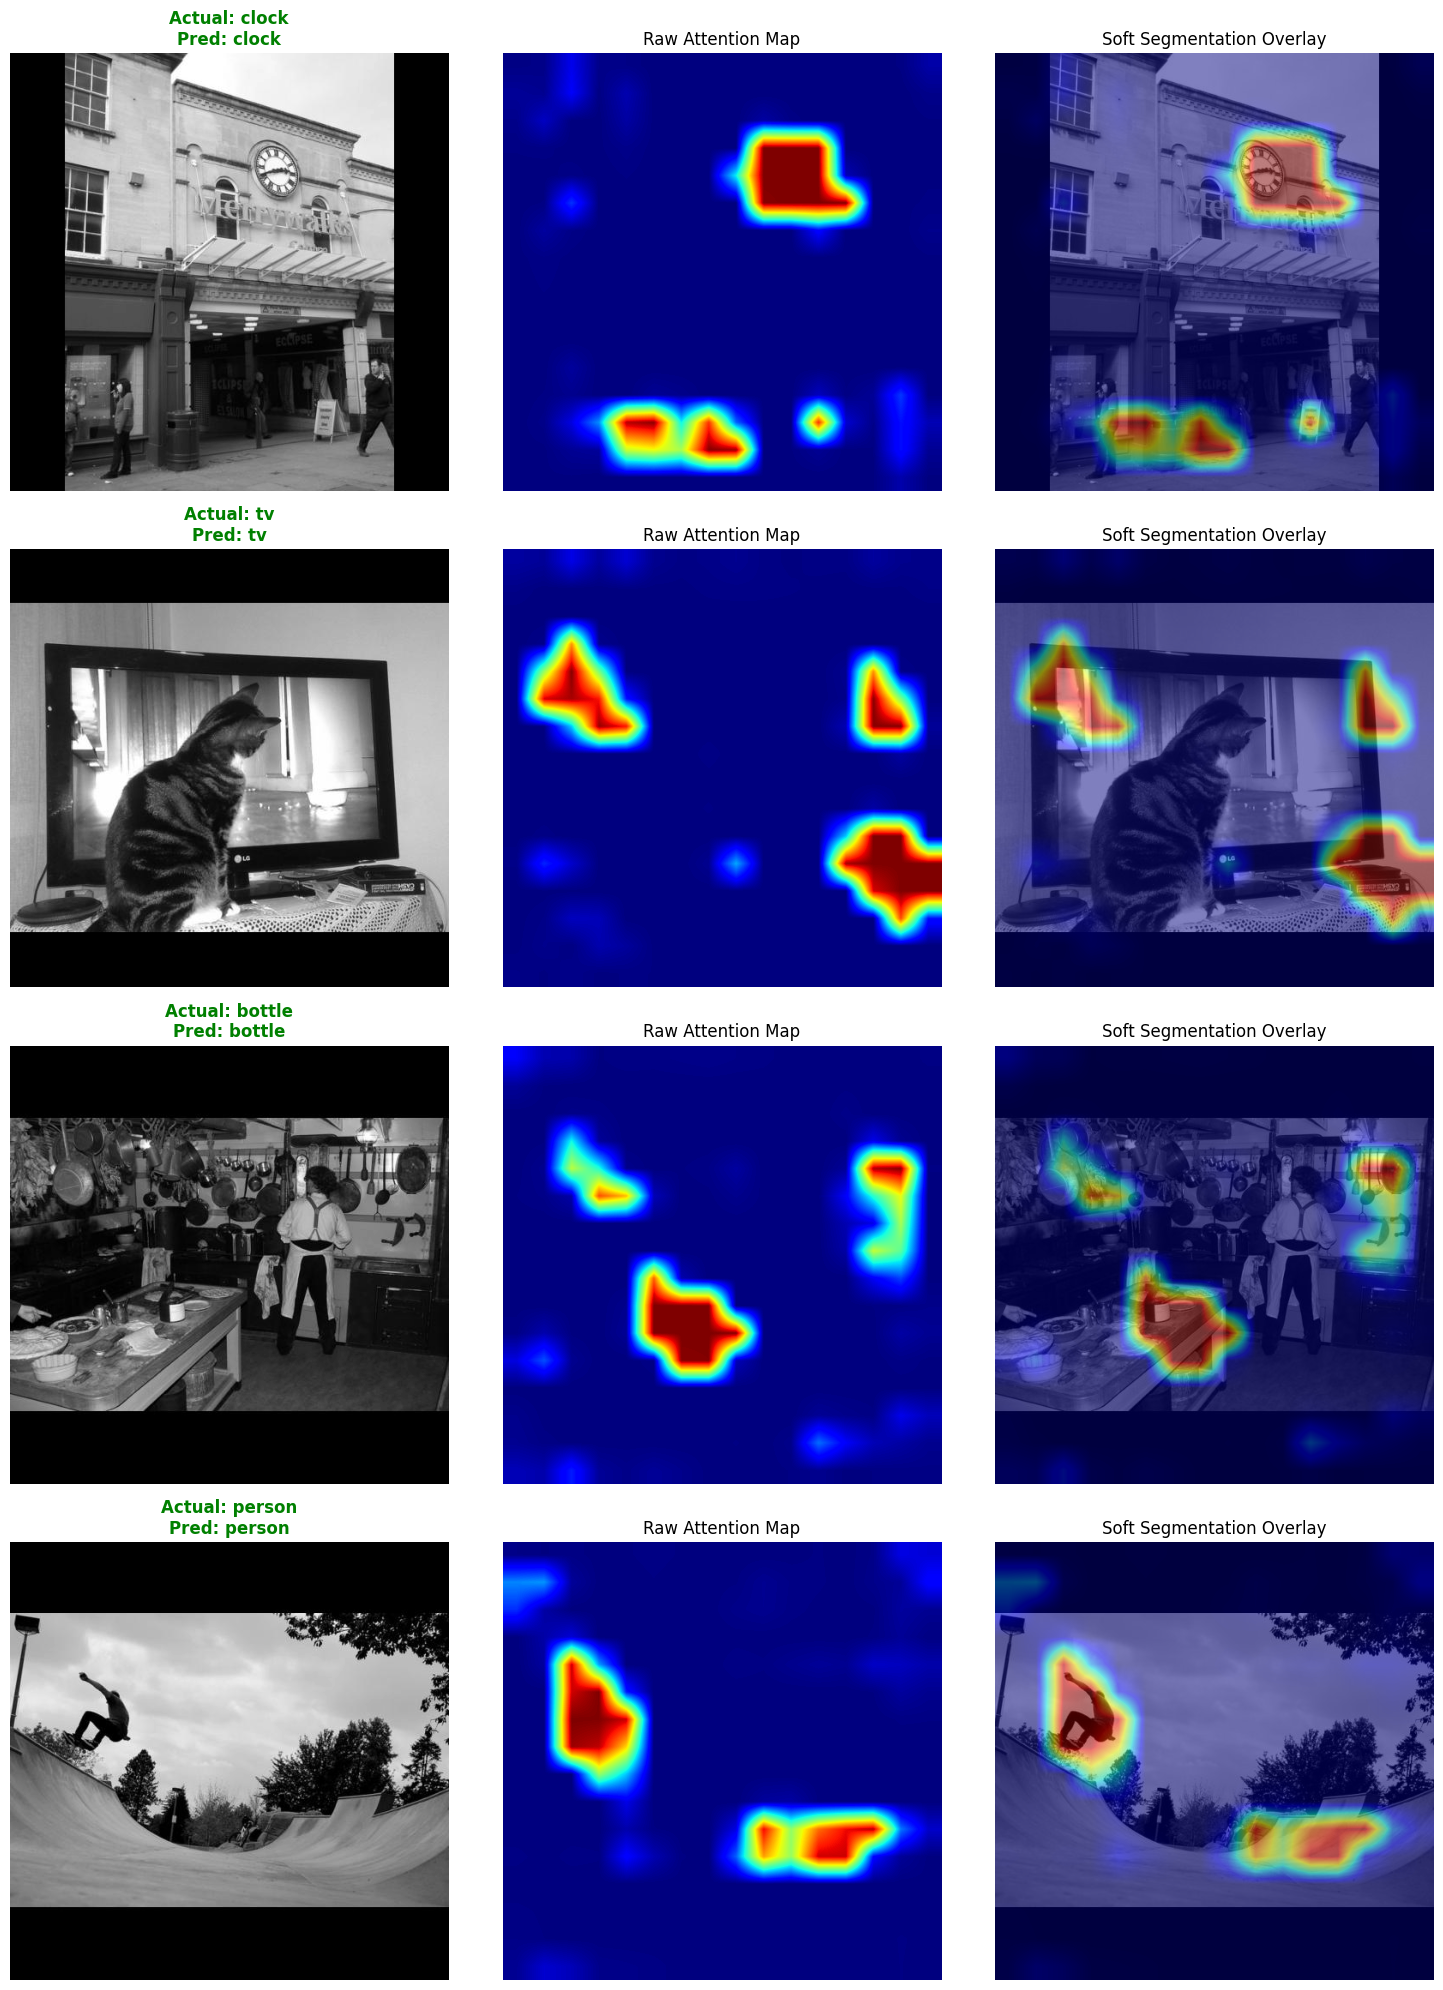

In [21]:
# CELL 4: Visualize Predictions & Maps (Diagnostic Mode)
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# 1. Get Batch
dataiter = iter(train_loader)
gray_imgs, rgb_imgs, labels = next(dataiter)
gray_imgs = gray_imgs.to(device)
labels = labels.to(device)

# 2. Inference
model.eval()
with torch.no_grad():
    outputs, attn_maps = model(gray_imgs)
    _, preds = torch.max(outputs, 1)

# 3. Hardcoded COCO Class Names
coco_classes = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# 4. Visualization
fig, axes = plt.subplots(4, 3, figsize=(15, 20))

for i in range(4):
    img_gray = gray_imgs[i].cpu().squeeze().numpy()[0, :, :]
    
    heatmap = F.interpolate(attn_maps, size=(512, 512), mode='bilinear', align_corners=False)
    heatmap = heatmap[i].cpu().squeeze().numpy()
    
    # Normalize for display
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + 1e-8)

    label_idx = labels[i].item()
    pred_idx = preds[i].item()
    
    actual_class = coco_classes[label_idx] if label_idx < len(coco_classes) else "Unknown"
    pred_class = coco_classes[pred_idx] if pred_idx < len(coco_classes) else "Unknown"
    color = 'green' if label_idx == pred_idx else 'red'

    axes[i, 0].imshow(img_gray, cmap='gray')
    axes[i, 0].set_title(f"Actual: {actual_class}\nPred: {pred_class}", color=color, fontweight='bold')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(heatmap, cmap='jet')
    axes[i, 1].set_title("Raw Attention Map")
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(img_gray, cmap='gray')
    axes[i, 2].imshow(heatmap, cmap='jet', alpha=0.5) 
    axes[i, 2].set_title("Soft Segmentation Overlay")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()